# Example of asynchronous requests (v > 1.1)
- The scope of this example is to show how to request several products together so that internal resource usage is maximized
- We extract the spectrum of the Crab in groups of nscw science windows for each semester from start_year to stop_year included
- We fit the spectra with a broken power law using xspec

In [1]:
#A few input parameters
osa_version="OSA10.2"
source_name="Crab"
nscw=5
start_year=2004
end_year=2006
oda_platform="production-1-2"
systematic_fraction = 0.01


In [2]:
#Example of functions to select a science window list
import time

use_heasarc = True # do!

if use_heasarc:
    #best method
    import astroquery.heasarc
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    
    Heasarc = astroquery.heasarc.Heasarc()
    
    def _get_scw_list(ra_obj, dec_obj,radius,start_date,end_date ):
        R = Heasarc.query_region(
                position = SkyCoord(ra_obj, dec_obj, unit='deg'), 
                radius = f"{radius} deg",
                mission = 'intscw',                 
                time = start_date + " .. " + end_date,
                good_isgri = ">1000",
            )        
        
        R.sort('SCW_ID')
        
        return R['SCW_ID'], R['SCW_VER']
    
    def get_scw_list(ra_obj, dec_obj,radius,start_date,end_date ):  
        for i in range(10):
            try:
                return _get_scw_list(ra_obj, dec_obj,radius,start_date,end_date )
            except Exception as e:
                print(e)
        raise RuntimeError

else:
    #Only for local ISDC users, as it requires access to local network
    import mysql.connector
    user='w3guest'
    passwd='guest'
    database='browsedb'

    cnx = mysql.connector.connect(user=user, password=passwd,
                                  host='10.194.169.139', port=3306,
                                  database=database)

    cursor = cnx.cursor()
    
    # end date ends up being

    def get_scw_list(ra_obj, dec_obj,radius,start_date,end_date ):
        scw_list=[]
        version=[]
        query = ("SELECT start_date, ing_dt, scw_id, scw_ver, obs_type, ps, pi_name, ra_x, dec_x, scw_ver " +
                 "FROM gadc_integral_rev3_scw " +
                 "WHERE start_date BETWEEN '{}' and '{}' ".format(start_date,end_date) +
                 "AND good_isgri > 1000 " +
                 "AND (ra_x-{})*(ra_x-{})+(dec_x-{})*(dec_x-{})<{}".format(ra_obj,ra_obj, dec_obj,dec_obj,radius**2) + 
                 " ORDER BY scw_id")
        # we can not really call this comparison selection by radius!
        cursor.execute(query)
        for start_date, ing_dt, scw_id, scw_ver, obs_type, ps, pi_name, ra_x, dec_x, scw_ver in cursor:
            #print(scw_id.decode(), start_date, ing_dt, ra_x, dec_x)
            scw_list.append(scw_id.decode())
            version.append(scw_ver.decode())
        return scw_list, version

def get_revs(scw_list):
    return sorted(list(set([a[0:4] for a in scw_list])))
    
       

In [3]:
import numpy as np
from astroquery.simbad import Simbad
from astropy import coordinates as coord

import json

import os
import shutil
import oda
import random

from astropy.io import fits

from scipy import stats
result_table = Simbad.query_object(source_name)
source_coord = coord.SkyCoord(result_table['RA'][0], result_table['DEC'][0], unit=("hourangle", "deg"))
ra=source_coord.ra.deg
dec=source_coord.dec.deg
radius=8.

#We hardcode a catalog for the Crab
api_cat={
    "cat_frame": "fk5", 
    "cat_coord_units": "deg", 
    "cat_column_list": [
        [0, 7], 
        ["1A 0535+262", "Crab"], 
        [125.4826889038086, 1358.7255859375], 
        [84.72280883789062, 83.63166809082031], 
        [26.312734603881836, 22.016284942626953], 
        [-32768, -32768], 
        [2, 2], 
        [0, 0], 
        [0.0002800000074785203, 0.0002800000074785203]], 
    "cat_column_names": [
        "meta_ID", 
        "src_names", 
        "significance", 
        "ra", 
        "dec", 
        "NEW_SOURCE", 
        "ISGRI_FLAG", 
        "FLAG", 
        "ERR_RAD"
    ], 
    "cat_column_descr": 
        [
            ["meta_ID", "<i8"], 
            ["src_names", "<U11"], 
            ["significance", "<f8"], 
            ["ra", "<f8"], 
            ["dec", "<f8"], 
            ["NEW_SOURCE", "<i8"], 
            ["ISGRI_FLAG", "<i8"], 
            ["FLAG", "<i8"], 
            ["ERR_RAD", "<f8"]
        ], 
    "cat_lat_name": "dec", 
    "cat_lon_name": "ra"
}



In [4]:
#Different instances of the platform, the first two are available only internally

import oda_api.api
import importlib
importlib.reload(oda_api)

def dispatcher(_oda_platform):
    disp = oda_api.api.DispatcherAPI(
        url = {
            'staging-1-3': 'http://in.internal.odahub.io/staging-1-3/dispatcher',
            'staging-1-2': 'http://cdcihn.isdc.unige.ch/staging-1.2/dispatcher',
            'production-1-2': 'https://www.astro.unige.ch/cdci/astrooda/dispatch-data',
        }[_oda_platform]
    )
    disp.get_instrument_description("isgri")
    return disp

if oda_platform == 'auto':
    # osa versions with '-' use ic root version, only available on staging-1-3
    print('will find appropriate API for OSA version', osa_version)

    if '-' in osa_version:
        print('osa version has subversion - will use staging-1-3')
        disp = dispatcher('staging-1-3')        
    else:
        try:
            disp = dispatcher('staging-1-2')        
            print('will use staging-1-2')
        except Exception as e:
            print('\033[31mFAILED to access staging-1-2, will proceed to query production: note that it can not access private data!\033[0m')
            print('\033[31mexception was: ', e,'\033[0m')
            try:
                disp = dispatcher('production-1-2')
            except:
                raise ConnectionError
else:
    print("custom platform selection:", oda_platform)
    disp = dispatcher(oda_platform)

    
    print("selected", disp.url)

custom platform selection: production-1-2

--------------
query_name: src_query
 name: src_name,  value: test,  units: str, 
 name: RA,  value: 0.0,  units: deg, 
 name: DEC,  value: 0.0,  units: deg, 
 name: T1,  value: 2001-12-11T00:00:00.000,  units: None, 
 name: T2,  value: 2001-12-11T00:00:00.000,  units: None, 

--------------
query_name: isgri_parameters
 name: user_catalog,  value: None,  units: str, 
 name: scw_list,  value: [],  units: names_list, 
 name: selected_catalog,  value: None,  units: str, 
 name: radius,  value: 5.0,  units: deg, 
 name: max_pointings,  value: 50,  units: None, 
 name: osa_version,  value: None,  units: str, 
 name: E1_keV,  value: 10.0,  units: keV, 
 name: E2_keV,  value: 40.0,  units: keV, 

--------------
query_name: isgri_image_query
 product_name: isgri_image
 name: detection_threshold,  value: 0.0,  units: sigma, 
 name: image_scale_min,  value: None,  units: None, 
 name: image_scale_max,  value: None,  units: None, 

--------------
query_

In [5]:
#Here, we collect and save spectra for each year and semester

spectrum_results=[]

disp_by_ys = {}
data_by_ys = {}

while True:
    spectrum_results=[]

    for year in range(start_year,end_year+1): 
        for semester in [1,2]:
            if semester ==1:
                T1_utc='%4d-01-01 00:00:00.0'%year
                T2_utc='%4d-06-30 23:59:59.0'%year # there are 30 days in June!
            else:
                T1_utc='%4d-07-01 00:00:00.0'%year
                T2_utc='%4d-12-31 23:59:59.0'%year 

            print(T1_utc,'-',T2_utc)

            scwlist, version = get_scw_list(ra, dec,radius, T1_utc, T2_utc)
            

            if len(scwlist) == 0:
                raise Exception('No science windows in %d semester %d'%(year,semester))

            scw_pick = [(s+"."+v).strip() for s,v in zip(scwlist,version)]
                 
            if nscw >0 and len(scw_pick)>=nscw:
                random.seed(0)
                scw_pick = random.sample(scw_pick, nscw)
            
            scw_list_str = ",".join(sorted(scw_pick))
            
            if '-' not in osa_version:
                if year >= 2016:
                    osa_version='OSA11.0'
                else:
                    osa_version='OSA10.2'
                    
            ys = (year, semester)

            if ys not in disp_by_ys:
                disp_by_ys[ys] = oda_api.api.DispatcherAPI(url=disp.url, wait=False)
            
            _disp = disp_by_ys[ys]

            data = data_by_ys.get(ys, None)

            if data is None:
                data = _disp.get_product(instrument='isgri',
                                  product='isgri_spectrum',
                                  osa_version=osa_version,
                                  product_type='Real',
                                  scw_list=scw_list_str,
                                  selected_catalog=json.dumps(api_cat))
                
                data_by_ys[ys] = data

                if not _disp.is_complete:
                    continue



            for ID,s in enumerate(data._p_list):
                if (s.meta_data['src_name']==source_name):
                    if(s.meta_data['product']=='isgri_spectrum'):
                        ID_spec=ID
                    if(s.meta_data['product']=='isgri_arf'):
                        ID_arf=ID
                    if(s.meta_data['product']=='isgri_rmf'):
                        ID_rmf=ID

            print(ID_spec, ID_arf, ID_rmf)

            spec=data._p_list[ID_spec].data_unit[1].data
            arf=data._p_list[ID_arf].data_unit[1].data
            rmf=data._p_list[ID_rmf].data_unit[2].data
            expos=data._p_list[0].data_unit[1].header['EXPOSURE']
            name=source_name+'_'+str(year)+'_%d'%semester
            specname=name+'_spectrum.fits'
            arfname=name+'_arf.fits.gz'
            rmfname=name+'_rmf.fits.gz'
            data._p_list[ID_spec].write_fits_file(specname)
            data._p_list[ID_arf].write_fits_file(arfname)
            data._p_list[ID_rmf].write_fits_file(rmfname)
            hdul = fits.open(specname, mode='update')
            hdul[1].header.set('EXPOSURE', expos)
            hdul[1].header['RESPFILE']=rmfname
            hdul[1].header['ANCRFILE']=arfname
            hdul[1].data['SYS_ERR']=systematic_fraction

            hdul.close()


            spectrum_results.append(data)
        
    n_complete = len([ year for year, _disp in disp_by_ys.items() if _disp.is_complete ])
    print(f"complete {n_complete} / {len(disp_by_ys)}")
    if n_complete == len(disp_by_ys):
        print("done!")
        break
    print("not done")


2004-01-01 00:00:00.0 - 2004-06-30 23:59:59.0
060500580120.001,072700140021.001,166700490010.001,192800520021.001,206600390010.001
- waiting for remote response (since 2021-02-17 09:56:35), please wait for https://www.astro.unige.ch/cdci/astrooda/dispatch-data/run_analysis

... query status prepared => submitted
... assigned job id: -3244283164185579599
 | the job is working remotely, please wait status=submitted job_id=-3244283 in 0 messages since 18 seconds; in 0 SCW so far; nodes (0): 0 computed 0 restored
query not complete, please poll again later
2004-07-01 00:00:00.0 - 2004-12-31 23:59:59.0
060500580120.001,072700140021.001,166700490010.001,192800520021.001,206600390010.001
- waiting for remote response (since 2021-02-17 09:56:53), please wait for https://www.astro.unige.ch/cdci/astrooda/dispatch-data/run_analysis

... query status prepared => submitted
... assigned job id: -3244283164185579599
 | the job is working remotely, please wait status=submitted job_id=-3244283 in 0 mes

2021-02-17 09:59:55 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'instrument' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2021-02-17 09:59:55 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'oda_api_version' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2021-02-17 09:59:55 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'osa_version' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2021-02-17 09:59:55 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'product_type' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2021-02-17 09:59:55 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'query_status' is greater than 8 characters or contains cha


... query status prepared => done
query COMPLETED SUCCESSFULLY (state done)
3 4 5
2006-01-01 00:00:00.0 - 2006-06-30 23:59:59.0
060500580120.001,072700140021.001,166700490010.001,192800520021.001,206600390010.001
- waiting for remote response (since 2021-02-17 09:59:55), please wait for https://www.astro.unige.ch/cdci/astrooda/dispatch-data/run_analysis


2021-02-17 10:00:25 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'instrument' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2021-02-17 10:00:25 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'oda_api_version' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2021-02-17 10:00:25 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'osa_version' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2021-02-17 10:00:25 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'product_type' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2021-02-17 10:00:25 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'query_status' is greater than 8 characters or contains cha


... query status prepared => done
query COMPLETED SUCCESSFULLY (state done)
3 4 5
2006-07-01 00:00:00.0 - 2006-12-31 23:59:59.0
060500580120.001,072700140021.001,166700490010.001,192800520021.001,206600390010.001
- waiting for remote response (since 2021-02-17 10:00:25), please wait for https://www.astro.unige.ch/cdci/astrooda/dispatch-data/run_analysis


2021-02-17 10:00:55 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'instrument' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2021-02-17 10:00:55 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'oda_api_version' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2021-02-17 10:00:55 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'osa_version' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2021-02-17 10:00:55 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'product_type' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2021-02-17 10:00:55 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'query_status' is greater than 8 characters or contains cha


... query status prepared => done
query COMPLETED SUCCESSFULLY (state done)
3 4 5
complete 3 / 6
not done
2004-01-01 00:00:00.0 - 2004-06-30 23:59:59.0
060500580120.001,072700140021.001,166700490010.001,192800520021.001,206600390010.001
- waiting for remote response (since 2021-02-17 10:00:55), please wait for https://www.astro.unige.ch/cdci/astrooda/dispatch-data/run_analysis


2021-02-17 10:01:25 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'instrument' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2021-02-17 10:01:25 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'oda_api_version' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2021-02-17 10:01:25 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'osa_version' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2021-02-17 10:01:25 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'product_type' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2021-02-17 10:01:25 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'query_status' is greater than 8 characters or contains cha


... query status prepared => done
query COMPLETED SUCCESSFULLY (state done)
3 4 5
2004-07-01 00:00:00.0 - 2004-12-31 23:59:59.0
060500580120.001,072700140021.001,166700490010.001,192800520021.001,206600390010.001
- waiting for remote response (since 2021-02-17 10:01:25), please wait for https://www.astro.unige.ch/cdci/astrooda/dispatch-data/run_analysis


2021-02-17 10:01:55 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'instrument' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2021-02-17 10:01:55 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'oda_api_version' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2021-02-17 10:01:55 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'osa_version' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2021-02-17 10:01:55 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'product_type' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2021-02-17 10:01:55 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'query_status' is greater than 8 characters or contains cha


... query status prepared => done
query COMPLETED SUCCESSFULLY (state done)
3 4 5
2005-01-01 00:00:00.0 - 2005-06-30 23:59:59.0
060500580120.001,072700140021.001,166700490010.001,192800520021.001,206600390010.001
- waiting for remote response (since 2021-02-17 10:01:55), please wait for https://www.astro.unige.ch/cdci/astrooda/dispatch-data/run_analysis


2021-02-17 10:02:27 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'instrument' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2021-02-17 10:02:27 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'oda_api_version' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2021-02-17 10:02:27 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'osa_version' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2021-02-17 10:02:27 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'product_type' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2021-02-17 10:02:27 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'query_status' is greater than 8 characters or contains cha


... query status prepared => done
query COMPLETED SUCCESSFULLY (state done)
3 4 5
2005-07-01 00:00:00.0 - 2005-12-31 23:59:59.0
3 4 5


2021-02-17 10:02:28 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'instrument' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2021-02-17 10:02:28 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'oda_api_version' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2021-02-17 10:02:28 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'osa_version' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2021-02-17 10:02:28 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'product_type' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2021-02-17 10:02:28 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'query_status' is greater than 8 characters or contains cha

2006-01-01 00:00:00.0 - 2006-06-30 23:59:59.0
3 4 5


2021-02-17 10:02:28 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'instrument' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2021-02-17 10:02:28 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'oda_api_version' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2021-02-17 10:02:28 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'osa_version' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2021-02-17 10:02:28 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'product_type' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2021-02-17 10:02:28 Casalingo astropy[91807] WARNING VerifyWarning: Keyword name 'query_status' is greater than 8 characters or contains cha

2006-07-01 00:00:00.0 - 2006-12-31 23:59:59.0
3 4 5
complete 6 / 6
done!


7
ISGRI ignore: **-20.00,500.-**
lg10Flux -7.84 False False
PhoIndx1 2.14 False False
PhoIndx2 1.84 False False


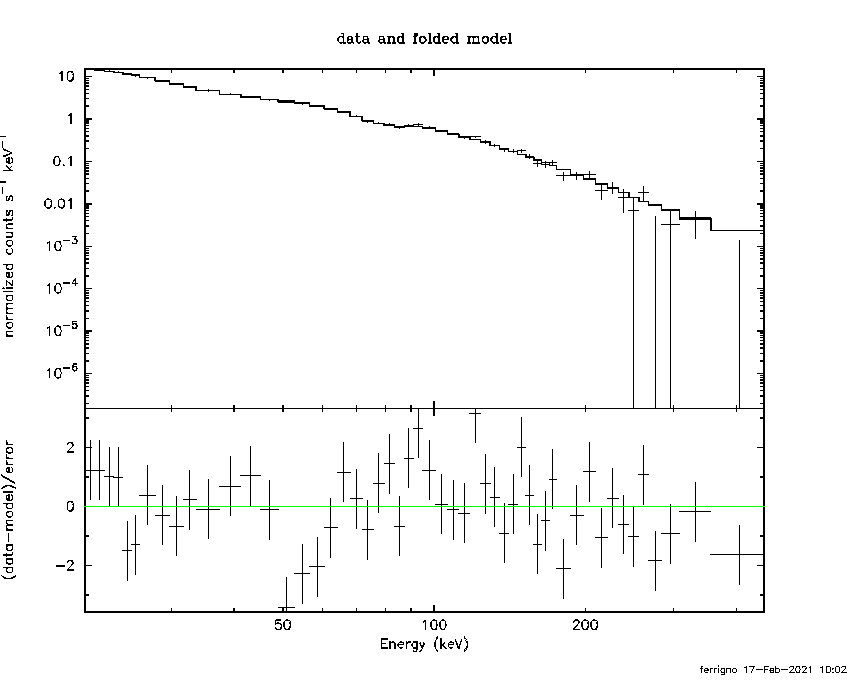

7
ISGRI ignore: **-20.00,500.-**
lg10Flux -7.84 False False
PhoIndx1 2.14 False False
PhoIndx2 1.84 False False


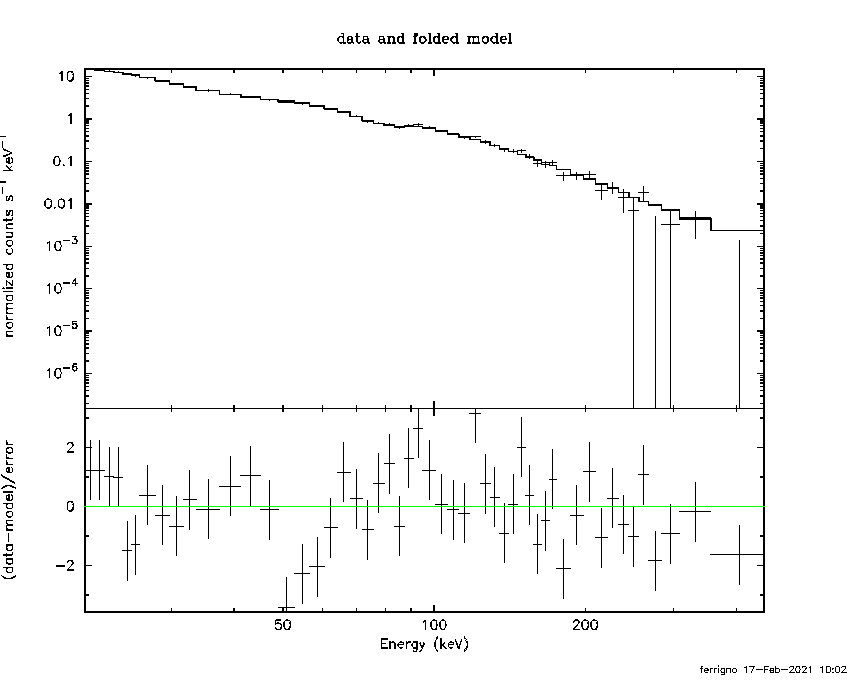

7
ISGRI ignore: **-20.00,500.-**
lg10Flux -7.84 False False
PhoIndx1 2.14 False False
PhoIndx2 1.84 False False


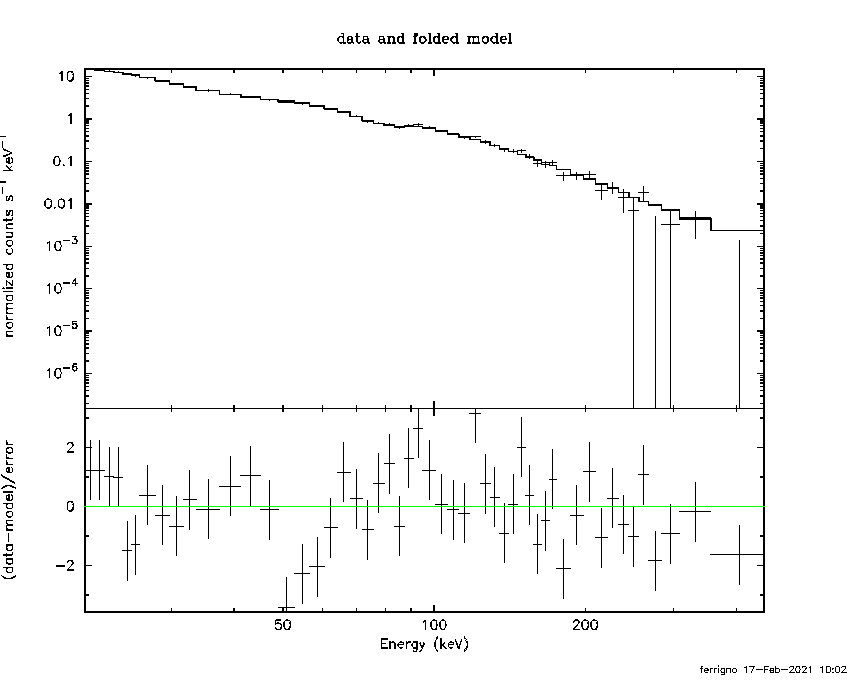

7
ISGRI ignore: **-20.00,500.-**
lg10Flux -7.84 False False
PhoIndx1 2.14 False False
PhoIndx2 1.84 False False


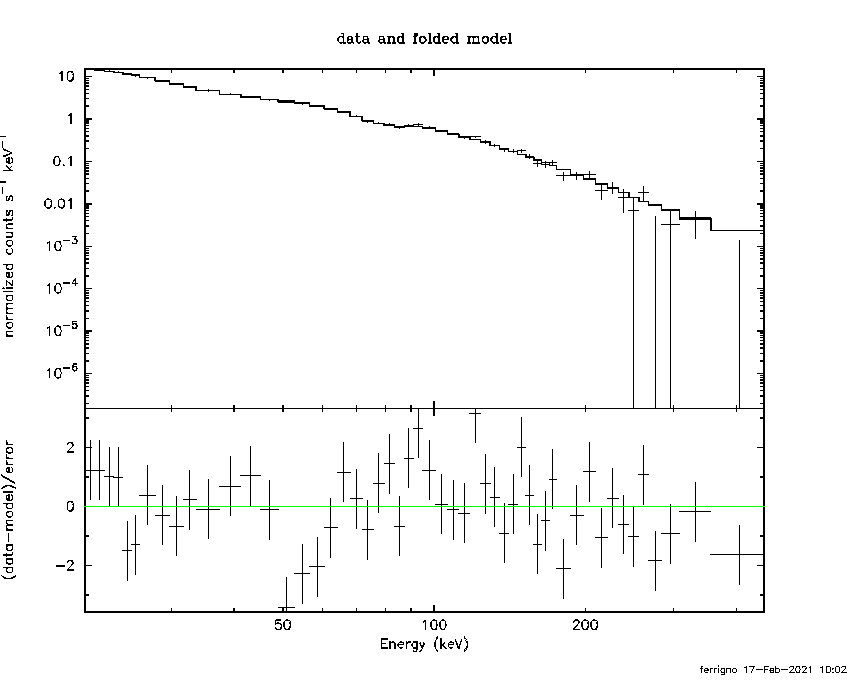

7
ISGRI ignore: **-20.00,500.-**
lg10Flux -7.84 False False
PhoIndx1 2.14 False False
PhoIndx2 1.84 False False


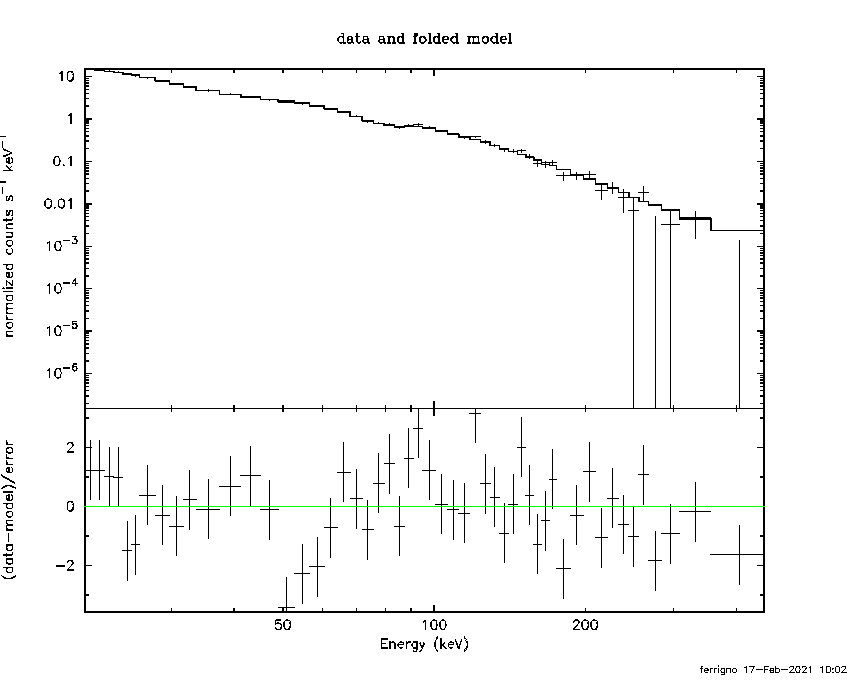

7
ISGRI ignore: **-20.00,500.-**
lg10Flux -7.84 False False
PhoIndx1 2.14 False False
PhoIndx2 1.84 False False


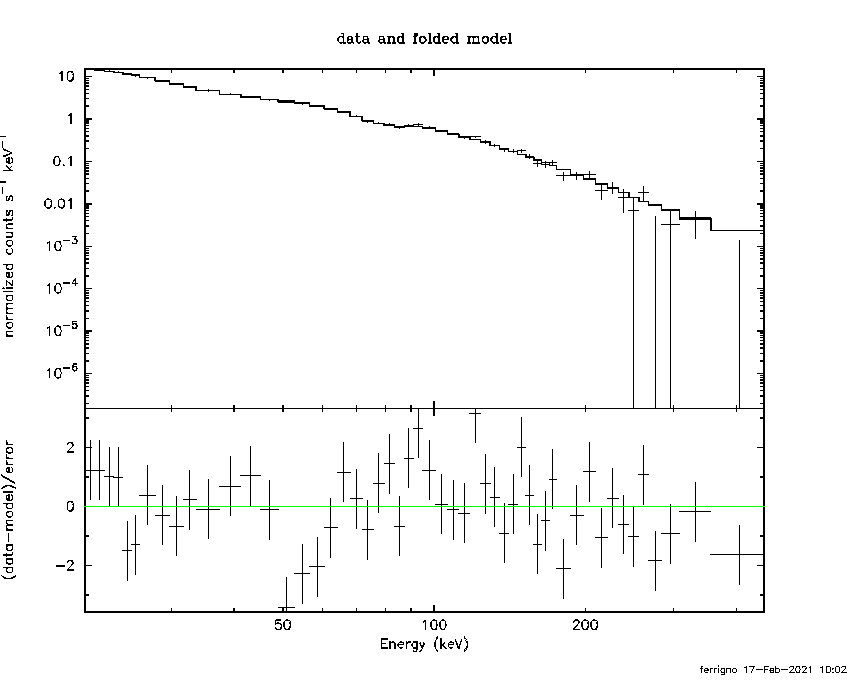

In [6]:
import xspec
import shutil
from IPython.display import Image
from IPython.display import display 

xspec.Fit.statMethod = "chi"

#init dictionaries
fit_by_lt={}

model='cflux*bknpow'

xspec.AllModels.systematic=0.0
low_energies=[20]
freeze_pow_ebreak=1

for year in range(start_year,end_year+1):

    for semester in [1,2]:

        for c_emin in low_energies: #np.linspace(17,40,5):    
            xspec.AllData.clear()

            m1=xspec.Model(model)

            specname=source_name+'_'+str(year)+'_%d'%semester+'_spectrum.fits'

            xspec.AllData(specname)

            s = xspec.AllData(1)

            isgri = xspec.AllModels(1)

            print(m1.nParameters)

            xspec.AllData.ignore('bad')
            xspec.AllData.ignore('500.0-**')

            ig="**-%.2f,500.-**"%c_emin
            print("ISGRI ignore: "+ ig)
            s.ignore(ig)

            #Key for output
            lt_key='%d_%d_%.10lg'%(year,semester, c_emin)

            isgri.cflux.lg10Flux=-8            

            isgri.cflux.Emin=20.
            isgri.cflux.Emax=80.

            isgri.bknpower.norm = "1,-1"
            isgri.bknpower.PhoIndx1 = "2.0,.01,1.,1.,3.,3."
            isgri.bknpower.PhoIndx2 = "2.2,.01,1.,1.,3.,3."
            isgri.bknpower.BreakE = "100,-1,20,20,300,300"

            xspec.Fit.perform()
            isgri.bknpower.BreakE.frozen = freeze_pow_ebreak  > 0

            xspec.Fit.perform()

            max_chi=np.ceil(xspec.Fit.statistic / xspec.Fit.dof)

            xspec.Fit.error("1.0 max %.1f 1-%d"%(max_chi,m1.nParameters))


            fit_by_lt[lt_key]=dict(
                    emin=c_emin,
                    year=year,
                    semester=semester,
                    chi2_red=xspec.Fit.statistic/xspec.Fit.dof,                                
                    chi2=xspec.Fit.statistic,
                    ndof=xspec.Fit.dof,                                    
                )

            for i in range(1,m1.nParameters+1): 
                if (not isgri(i).frozen) and (not bool(isgri(i).link)):
                    #use the name plus position because there could be parameters with same name from multiple 
                    #model components (e.g., several gaussians)
                    print(isgri(i).name, "%.2f"%(isgri(i).values[0]), isgri(i).frozen,bool(isgri(i).link) )
                    fit_by_lt[lt_key][isgri(i).name+"_%02d"%(i)]=[ isgri(i).values[0], isgri(i).error[0], isgri(i).error[1] ]



            xspec.Plot.device="/png"
            #xspec.Plot.addCommand("setplot en")
            xspec.Plot.xAxis="keV"
            xspec.Plot("ldata del")
            xspec.Plot.device="/png"

            fn="fit_%s.png"%lt_key
            fit_by_lt[lt_key]['plot_fname'] = fn

            shutil.move("pgplot.png_2", fn)

            _=display(Image(filename=fn,format="png"))

